# Тестовое задание на позицию Game Product Analyst - Бурый Артём
<div style="text-align: right"><a target="_blank" href="https://www.linkedin.com/in/artsiom-bury/">LinkedIn</a></div>
<div style="text-align: right"><a target="_blank" href="https://github.com/artsiom-bury/ZM_test_task/blob/main/ZM_test_task.ipynb">Ссылка на ipynb</a></div>

Для начала подключим все необходимые дальше библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, shapiro, levene

### 1) Задание по прогнозированию.
Есть исходные данные по когорте пользователей, совершающих определённое действие в приложении:

In [2]:
columns = ['day','share']
data = [[0,0.7123],
	[1,0.2279],
	[2,0.1883],
	[3,0.1758],
	[4,0.1598],
	[5,0.1559],
	[6,0.1459],
	[7,0.1373],
	[10,0.115],
	[14,0.1026],
	[17,0.0994],
	[21,0.0907],
	[24,0.0838],
	[28,0.0837]]
df = pd.DataFrame(data=data, columns=columns)
df.columns

Index(['day', 'share'], dtype='object')

Нужно:

1.1) найти оптимальную аппроксимирующую функцию, по которой можно прогнозировать будущие значения, и записать формулу данной функции с оптимизированными коэффициентами.

1.2) визуализировать на графике исходные данные, а также значения аппроксимирующей функции в диапазоне от 0 до 120 дня.

Визуализируем данные

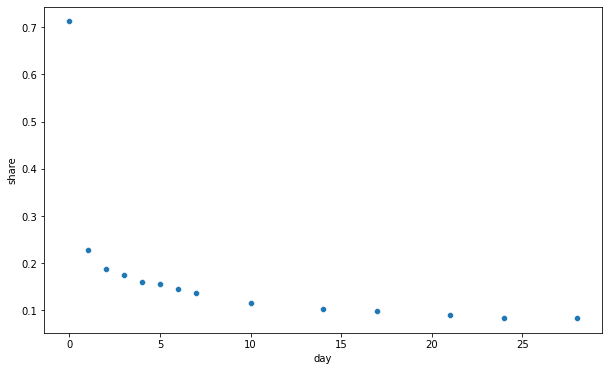

In [3]:
fig = plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='day', y='share')
plt.show()

Тут сразу понятно, две вещи:
1. Первая точка будет сильно мешать (сильное изменение, плюс она в нуле), её пытаться фитить не надо. К тому же нам важно экстраполировать результаты на дни 29-120, а не интерполировать между существующими точками
2. Функция на бесконечности должна стремиться к нулю

Соответсвенно, мы логарифмируем x и y без первой точки и видим красивую линейную зависимость

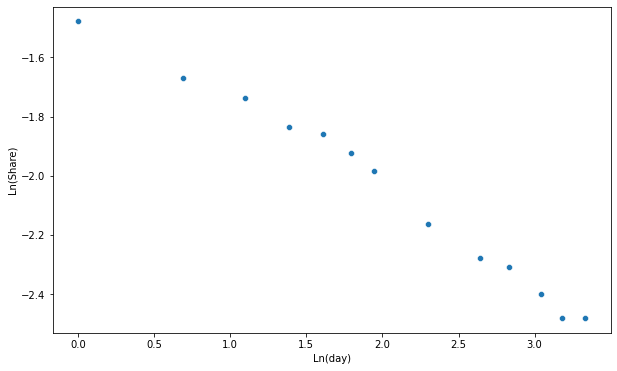

In [4]:
fig = plt.figure(figsize=(10,6))
sns.scatterplot(x=np.log(df['day'].iloc[1:]), y=np.log(df['share'].iloc[1:]))
plt.xlabel("Ln(day)")
plt.ylabel("Ln(Share)")
plt.show()

Фитим её и получаем следующую формулу для изначальных данных:

In [5]:

reg = LinearRegression().fit(np.log(df[['day']][1:]), np.log(df['share'][1:]))

print(f'y = {np.round(np.exp(reg.intercept_),4)} * x^({np.round(reg.coef_[0],4)})')

y = 0.2436 * x^(-0.3186)


Ну и строим фит до 120 дня вместе с изначальными точками, чтобы убедиться, что всё хорошо

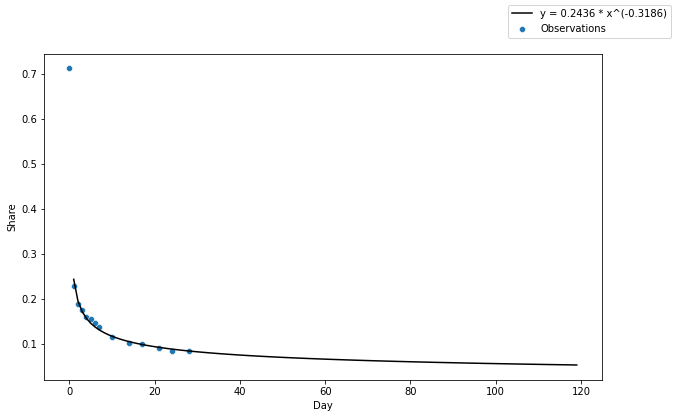

In [6]:
fig = plt.figure(figsize=(10,6))
sns.lineplot(x=np.arange(1,120,1), y=np.exp(reg.intercept_)* (np.arange(1,120,1) ** reg.coef_[0]), color='black')
sns.scatterplot(x=df['day'],y=df['share'])
plt.xlabel("Day")
plt.ylabel("Share")
fig.legend(labels=['y = 0.2436 * x^(-0.3186)','Observations'])
plt.show()

## 2) Задача по теории вероятности.

В банке лежит 5 игральных костей (4-сторонняя, 6-сторонняя, 8-сторонняя, 12-сторонняя, 20-сторонняя).  Игрок выбрал случайным образом кость, бросил её и на ней выпало значение 5. Нужно определить вероятность для каждой из 5 игральных костей, что была выбрана именно она.

Это классическая задача на теорему Байеса. Запишем вероятности выпадения 5 на всех костях. И посчитаем для них всех вероятность, что мы вытащили именно эту кость, считая, что все кости вытягиваются равновероятно

In [7]:
p = [0,1/6,1/8,1/12,1/20]
s = sum(p)*1/5
for i,dice in enumerate([4,6,8,12,20]):
    print(f'Вероятность, что мы вытянули {dice}-стороннюю кость: ~{np.round(p[i]*1/5/s*100,2)}%')


Вероятность, что мы вытянули 4-стороннюю кость: ~0.0%
Вероятность, что мы вытянули 6-стороннюю кость: ~39.22%
Вероятность, что мы вытянули 8-стороннюю кость: ~29.41%
Вероятность, что мы вытянули 12-стороннюю кость: ~19.61%
Вероятность, что мы вытянули 20-стороннюю кость: ~11.76%


## 3) Задание по анализу результата A/B эксперимента.

В файле "experiment_data.csv" сохранены результаты A/B эксперимента. Нужно проанализировать, есть ли статистически значимая разница анализируемой метрики между двумя вариантами.
Следует:
1) обосновать выбранный метод анализа;
2) продемострировать код для анализа на Python (например в Jupyter Notebook и т.п.); 
3) предоставить и объяснить результаты анализа

Сразу стоит оговорить один важный момент:

Продуктовый аналитик не анализирует результаты АБ теста, а занимается его дизайном с самого начала. Мне очень сложно сделать какие-то выводы, когда я не знаю, что я анализирую. Может, у нас экзотическая цель, например, изменить дисперсию наших данных. Или может быть в этих данных есть аномалии во времени, которые надо отсечь

Тем не менее посмотрим на данные

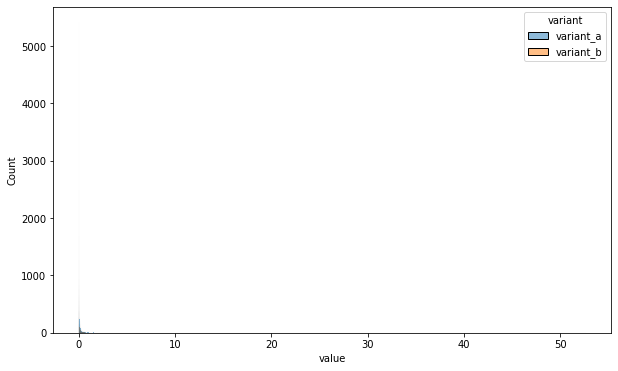

In [8]:
df = pd.read_csv('experiment_data.csv')

fig = plt.figure(figsize=(10,6))
sns.histplot(data=df, x='value', hue='variant')
plt.show()

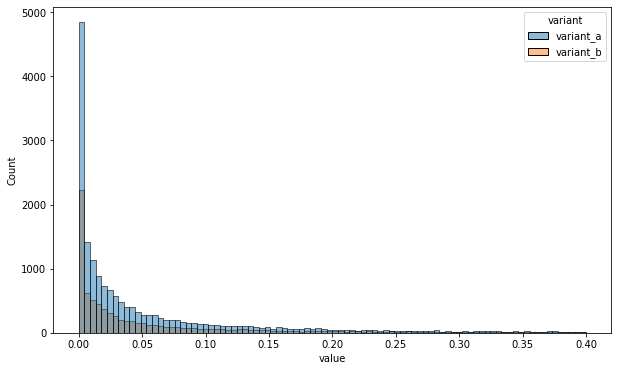

In [9]:
df = pd.read_csv('experiment_data.csv')

fig = plt.figure(figsize=(10,6))
sns.histplot(data=df[df['value']<=0.4], x='value', hue='variant')
plt.show()

In [10]:
print('Variant A')
display(df[df['variant']=='variant_a']['value'].describe())
print('Variant B')
display(df[df['variant']=='variant_b']['value'].describe())

Variant A


count    18731.000000
mean         0.147163
std          0.660557
min          0.000000
25%          0.004000
50%          0.024500
75%          0.094600
max         52.672400
Name: value, dtype: float64

Variant B


count    8661.000000
mean        0.148885
std         0.574914
min         0.000000
25%         0.004000
50%         0.024400
75%         0.097100
max        21.754500
Name: value, dtype: float64

Вопросов к этим данным стало ещё больше, чем было сначала, конечно :)

Особенности наших данных:
1. Длинный "хвост" из единичных данных справа
2. Разные объёмы выборок
3. Предположительно статзначимо разные дисперсии

Без лишних комментариев проведем пару тестов

In [11]:
a = df[df['variant']=='variant_a']['value']
b = df[df['variant']=='variant_b']['value']

print("Тест на нормальность данных группы А (Shapiro–Wilk test). Если p-value > 0.05, то данные распределены нормально")
display(shapiro(a))
print("Тест на нормальность данных группы B (Shapiro–Wilk test). Если p-value > 0.05, то данные распределены нормально")
display(shapiro(b))
print("Тест на различие дисперсий группы А и B при условии, что данные не распределены нормально (Levene's test). Если p-value > 0.05, то дисперсии статзначимо не различаются")
display(levene(a,b,center='trimmed'))

a_sample_list = []
b_sample_list = []
for i in range(5000):
    a_sample = a.sample(frac=1, replace=True)
    b_sample = b.sample(frac=1, replace=True)
    a_sample_list.append(a_sample.mean())
    b_sample_list.append(b_sample.mean())
print("Тест на нормальность среднего сэмплов из данных группы А (Shapiro–Wilk test). Если p-value > 0.05, то данные распределены нормально")
display(shapiro(a_sample_list))
print("Тест на нормальность среднего сэмплов из данных группы B (Shapiro–Wilk test). Если p-value > 0.05, то данные распределены нормально")
display(shapiro(b_sample_list))


Тест на нормальность данных группы А (Shapiro–Wilk test). Если p-value > 0.05, то данные распределены нормально


ShapiroResult(statistic=0.16865891218185425, pvalue=0.0)

Тест на нормальность данных группы B (Shapiro–Wilk test). Если p-value > 0.05, то данные распределены нормально


ShapiroResult(statistic=0.22086435556411743, pvalue=0.0)

Тест на различие дисперсий группы А и B при условии, что данные не распределены нормально (Levene's test). Если p-value > 0.05, то дисперсии статзначимо не различаются


LeveneResult(statistic=4.790197302698688, pvalue=0.02863149620766008)

Тест на нормальность среднего сэмплов из данных группы А (Shapiro–Wilk test). Если p-value > 0.05, то данные распределены нормально


ShapiroResult(statistic=0.9943662285804749, pvalue=4.292564025586143e-13)

Тест на нормальность среднего сэмплов из данных группы B (Shapiro–Wilk test). Если p-value > 0.05, то данные распределены нормально


ShapiroResult(statistic=0.9985847473144531, pvalue=0.00021036557154729962)

1. Данные не распределены нормально
2. У групп А и В разная дисперсия
3. Статистика по данным тоже не распределена нормально!

Довольно редкий кейс, вообще говоря. Тут сухой матстат должен уступить место некоторому креативу. Лично я хочу посмотреть, что будет, если я обрежу хвост настолько, чтобы статистика по данным стала распределена нормально. Тогда можно будет применить Welch's t-test. 

In [12]:
for border in np.arange(20,0.5,-0.5):
    a = df[(df['variant']=='variant_a') & (df['value']<=border)]['value']
    b = df[(df['variant']=='variant_b') & (df['value']<=border)]['value']

    a_sample_list = []
    b_sample_list = []
    for i in range(5000):
        a_sample = a.sample(frac=1, replace=True)
        b_sample = b.sample(frac=1, replace=True)
        a_sample_list.append(a_sample.mean())
        b_sample_list.append(b_sample.mean())
    if (shapiro(a_sample_list).pvalue > 0.05) & (shapiro(b_sample_list).pvalue > 0.05):
        border = border
        print(border)
        break

10.5


С данными выше 10.5 разберемся отдельно. А для тех, что ниже применим Welch's t-test

In [13]:
a = df[(df['variant']=='variant_a') & (df['value']<=border)]['value']
b = df[(df['variant']=='variant_b') & (df['value']<=border)]['value']

display(ttest_ind(a, b, equal_var=False))
display(levene(a,b,center='trimmed'))


Ttest_indResult(statistic=-0.26117000899281373, pvalue=0.7939645286502695)

LeveneResult(statistic=4.705485809857357, pvalue=0.030076031055470846)

Довольно закономерный итог: статзначимой разницы в средних для обрезанных по 10.5 данных нет. А дисперсии всё ещё различаются.

Теперь посмотрим на "хвост"

In [14]:
df[(df['value']>border)]

,Unnamed: 0,variant,value
1080,1080,variant_b,21.7545
2479,2479,variant_a,12.6421
2940,2940,variant_b,11.8647
9881,9881,variant_a,18.0493
14144,14144,variant_a,15.2240
18944,18944,variant_b,16.7875
22933,22933,variant_a,52.6724
23405,23405,variant_a,15.2404
24843,24843,variant_a,15.7954
25605,25605,variant_b,10.8578


Неожиданный поворот :) Их всего 10 штук, анализировать столь малые по объёму данные не стоит. Но поразительно, как всего 10 значений портят всё :)

Общий вывод: Статзначимого различия средних нет, статзначимое различие дисперсий есть. Но тут важно, что в идеале надо разобраться всё-таки во всех сомнениях, которые я описывал выше.

P.S. Это реальные данные?